In [398]:
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import LeakyReLU
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [399]:
data = pd.read_csv('bitcoin.csv').drop(['time_period_start', 'time_period_end', 'time_open', 'time_close'], axis=1)
data.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,7165.72,7165.72,7165.71,7165.71,0.021841,2
1,7168.30,7168.30,7168.30,7168.30,1.000000,2
2,7170.50,7170.50,7170.50,7170.50,0.002000,1
3,7169.20,7169.20,7169.20,7169.20,0.004000,2
4,7169.20,7169.20,7169.20,7169.20,0.002000,1


In [400]:
scaler = MinMaxScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])
data.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,0.267495,0.264047,0.339554,0.267368,0.000336,0.011494
1,0.300203,0.296333,0.369204,0.300203,0.015381,0.011494
2,0.328093,0.323864,0.394390,0.328093,0.000031,0.000000
3,0.311613,0.307596,0.379508,0.311613,0.000061,0.011494
4,0.311613,0.307596,0.379508,0.311613,0.000031,0.000000


Let's take a look at how the price fluctuates over time.

Text(0.5, 1.0, 'Price over entire dataset')

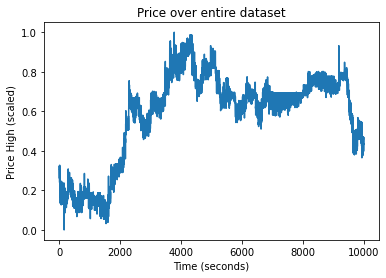

In [422]:
#data_minimal = data.drop(['price_open','price_low','price_close'], axis=1)
price_high_values = data['price_high'].values
plt.plot(price_high_values)
plt.xlabel("Time (seconds)")
plt.ylabel("Price High (scaled)")
plt.title("Price over entire dataset")

Text(0.5, 1.0, 'Four different windows of price fluctuations')

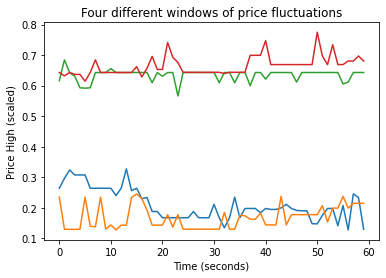

In [423]:
plt.plot(price_high_values[0:60])
plt.plot(price_high_values[60:120])
plt.plot(price_high_values[6060:6120])
plt.plot(price_high_values[6120:6180])
plt.xlabel("Time (seconds)")
plt.ylabel("Price High (scaled)")
plt.title("Four different windows of price fluctuations")

Viewing a few 60 second windows, it is readily apparent that the noise is typically on the order of any trend that occurs.  I imagine this is going to make prediction quite difficult.  Even if we capture the trend, we are only extrapolating 1 second into the future and the noise is going to dominate.

I will investigate LSTM to see if we can fix the prediction.  Then I will try another model for comparison.

## Lookback Window

In order to capture the past as features, we create the below function. It takes as input some number of seconds to look back, defaulted to 60 seconds.

In [403]:
def lookback(dataset, timesteps = 60):
    # this uses the shift method of pandas dataframes to shift all of the columns down one row
    # and then append to the original dataset
    data = dataset
    for i in range(1, timesteps):
        step_back = dataset.shift(i).reset_index()
        step_back.columns = ['index'] + [f'{column}_-{i}' for column in dataset.columns if column != 'index']
        data = data.reset_index().merge(step_back, on='index', ).drop('index', axis=1)
        
    return data.dropna()
        
features = lookback(data)

features.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count,price_open_-1,price_high_-1,price_low_-1,price_close_-1,...,price_low_-58,price_close_-58,volume_traded_-58,trades_count_-58,price_open_-59,price_high_-59,price_low_-59,price_close_-59,volume_traded_-59,trades_count_-59
59,0.131212,0.129521,0.216600,0.131212,0.030762,0.011494,0.236815,0.233763,0.311963,0.236815,...,0.369204,0.300203,0.015381,0.011494,0.267495,0.264047,0.339554,0.267368,0.000336,0.011494
60,0.210193,0.235014,0.287922,0.238083,0.000243,0.011494,0.131212,0.129521,0.216600,0.131212,...,0.394390,0.328093,0.000031,0.000000,0.300203,0.296333,0.369204,0.300203,0.015381,0.011494
61,0.131339,0.129646,0.216600,0.131339,0.000590,0.022989,0.210193,0.235014,0.287922,0.238083,...,0.379508,0.311613,0.000061,0.011494,0.328093,0.323864,0.394390,0.328093,0.000031,0.000000
62,0.131339,0.129646,0.216714,0.131339,0.000495,0.000000,0.131339,0.129646,0.216600,0.131339,...,0.379508,0.311613,0.000031,0.000000,0.311613,0.307596,0.379508,0.311613,0.000061,0.011494
63,0.131212,0.129521,0.216600,0.131212,0.030762,0.000000,0.131339,0.129646,0.216714,0.131339,...,0.339668,0.311613,0.001160,0.022989,0.311613,0.307596,0.379508,0.311613,0.000031,0.000000


In [404]:
### split data into features and target
target = features['price_high'].values
features = features.drop('price_high', axis=1).values

All of the predictions being zero seems like a common issue that would come up for other people.  Since the stated goal is to get this model working quickly, I see nothing wrong with checking what google has to offer.

Based on https://github.com/keras-team/keras/issues/3687 we are going to experiment with different activation functions to see if that resolves the "predictions are all zero" issue.  This is the first I've heard of LeakyReLU.  If I understand it correctly, it's just ReLU with a slight slope on the part of the function that is normally horizontal.  This is a continuation of the same strategy behind using ReLU over a logistic.  After some tweaking I found a value of alpha (slope) I'm happy with.

In [405]:
model = Sequential()
model.add(Dense(32, input_dim=features.shape[1]))
model.add(Dense(16))
model.add(Dense(8))
#model.add(Dense(1, activation='relu'))
#model.add(Dense(1, activation='tanh'))
#model.add(Dense(1, activation=LeakyReLU(alpha=0.17)))
model.add(Dense(1))
model.add(LeakyReLU(alpha=0.17))

model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01), # is this the best optimizer/learning rate?
    metrics=['mean_squared_error', 'mean_absolute_error'] # does accuracy make sense in this context?
)

## callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='auto',
    restore_best_weights=True
)


history = model.fit(
    features,
    target,
    validation_split=.3,
    epochs=20,
    verbose=0
)

In [406]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 32)                11520     
_________________________________________________________________
dense_109 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_110 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 9         
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 1)                 0         
Total params: 12,193
Trainable params: 12,193
Non-trainable params: 0
_________________________________________________________________


The RMSE (0.6243527047317609 using "relu" and minmax scaled data) was drastically improved by changing to LeakyReLU and we are now producing non-zero predictions.

In [407]:
## prediction
predictions = model.predict(features)

In [408]:
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))

In [409]:
rmse

0.02200846512272496

In [410]:
predictions

array([[0.17444965],
       [0.188965  ],
       [0.17939758],
       ...,
       [0.44997862],
       [0.4573252 ],
       [0.43692008]], dtype=float32)

The big question now is: are the predictions valuable?  I have a sneaking suspicion that we're not doing much better than averaging the price over the previous 60 seconds to predict the price next second.  Or even using the previous second to predict the next.

Text(0.5, 1.0, 'LTSM predictions with LeakyReLU')

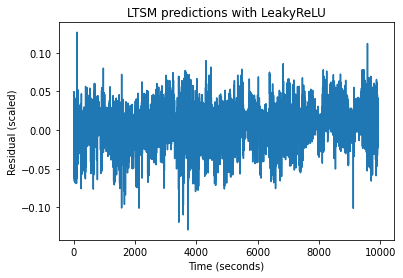

In [425]:
diff = np.subtract(predictions.ravel(),target)
plt.plot(diff)
plt.xlabel("Time (seconds)")
plt.ylabel("Residual (scaled)")
plt.title("LTSM predictions with LeakyReLU")

Let's see how this compares to guessing that the price the next second will match the price the current second.

In [412]:
target_now = target[1:]
target_before = target[0:len(target)-1]
diff_previous_second = target_now - target_before

rmse_previous_second = np.sqrt(np.mean(np.square((diff_previous_second))))
rmse_previous_second



0.0312238180383741

Text(0.5, 1.0, 'Predicted price = previous second price')

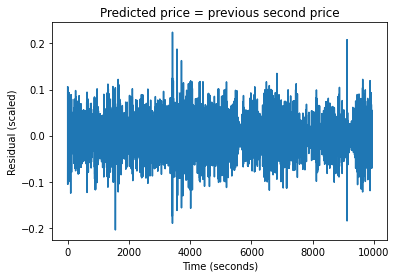

In [426]:
plt.plot(diff_previous_second)
plt.xlabel("Time (seconds)")
plt.ylabel("Residual (scaled)")
plt.title("Predicted price = previous second price")

Okay, some good-ish news there.  We seem to be doing slightly better than the most naive model I could conceive.  It seems we're at least getting some value from the lookback function.

Let's compare with the average as well.

In [414]:
def lookback_average(array, timesteps = 60):
    # this uses the shift method of pandas dataframes to shift all of the columns down one row
    # and then append to the original dataset
    len_array = len(array)
    len_array_average = len_array - timesteps
    array_target = array[60:len_array]
    lookback_average_array = np.zeros(len_array_average)
    for i in range(len_array_average):
        lookback_mean = array[i:i + timesteps].mean()
        lookback_average_array[i] = lookback_mean
        
        
    return lookback_average_array, array_target

price_average_previous_sixty_seconds, price_next_second = lookback_average(target)
diff_average = price_next_second - price_average_previous_sixty_seconds
rmse_average = np.sqrt(np.mean(np.square((diff_average))))
rmse_average

0.032686241855327786

We are also doing a little better than just averaging over the previous 60 seconds.

Without knowing too much about LTSM networks, I would like to do one other model for comparison.  I expect a simple linear regression would fail miserably as it would not capture any meaningful relationship between the trade volume and the target price.  I will instead use a random forest.

In [415]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, target, test_size = 0.3, random_state = 314)

rf = RandomForestRegressor(n_estimators=200, random_state=314)

rf.fit(train_features, train_labels)

predictions_rf = rf.predict(test_features)

In [416]:
predictions_rf

array([0.75049111, 0.82890114, 0.51789252, ..., 0.29165315, 0.78463462,
       0.85613287])

In [417]:
test_labels

array([0.74984357, 0.82880741, 0.5179577 , ..., 0.29145288, 0.78425729,
       0.85446127])

In [418]:
rmse_rf = np.sqrt(np.mean(np.square((test_labels - predictions_rf))))
rmse_rf

0.0054356869263232676

Random forest seems to be doing quite well.

In fact it's doing so well that I was worried I hadn't done a train_test_split properly.  But I double-checked and it looks good (with a caveat).

This feels like a good time to address one of my concerns: Data Leakage.  The lookback window smears information from the previous sixty seconds into the next second.  This means that a randomized validation split is going to pollute test data with train data.  Ideally I would advise splitting the data before applying the lookback, but this is nontrivial since lookback will get a random collection of datapoints going back further than 60 seconds.  We can do a split without shuffling and be careful at the edges, but I think I've hit the "a few hours" mark so I'll put a pin in it for now.